In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
from desi_retriever.denali import get_specs
import matplotlib.cm as cm
import scipy.ndimage as sn

In [38]:
def print_simple_number(truth_table,object_type):
    total_N = len(truth_table)
    good_N = len(truth_table[truth_table['best_quality']>=2.5])
    very_good_N = len(truth_table[truth_table['best_quality']==4])
    tmp_table = truth_table[truth_table['best_quality']>=2.5]
    number_of_consistent_z = len(tmp_table.loc[abs(tmp_table['best_z']-tmp_table['Redrock_z'])/(1+tmp_table['best_z'])<0.0033])
    
    print('Number of',object_type,':',total_N)
    print('Number of ',object_type,'with quality>=2.5:',good_N, ' | fration=',good_N*1.0/total_N)
    print('Number of ',object_type,'with quality==4:',very_good_N, ' | fration=',very_good_N*1.0/total_N)
    print('Number of ',object_type,'with consistent z (with quality>=2.5):',number_of_consistent_z, '| fraction=',number_of_consistent_z/total_N)
   
    number_star = len(tmp_table.loc[tmp_table['best_spectype']=='STAR'])
    number_galaxy = len(tmp_table.loc[tmp_table['best_spectype']=='GALAXY'])
    number_qso = len(tmp_table.loc[tmp_table['best_spectype']=='QSO'])
    print('---------')  
    print('Fraction of objects with quality>=2.5')
    print('Star:',number_star*1.0/good_N)
    print('Galaxy:',number_galaxy*1.0/good_N)    
    print('QSO:',number_qso*1.0/good_N)

    plt.hist(truth_table['best_quality'],bins=8,range=(0,4))
    plt.ylabel('Number')
    plt.xlabel('Quality')
    plt.yscale('log')
    plt.xlim(0,4)
  

In [3]:
def plot_redshift_distribution(truth_table,object_type):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    x_range = [0,max(truth_table.loc[truth_table['best_quality']>=2.5]['best_z'])]
    plt.hist(truth_table['best_z'],range=(x_range[0],x_range[1]),bins=20,color='b',label='All')
    plt.hist(truth_table.loc[truth_table['best_quality']>=2.5]['best_z'],range=(x_range[0],x_range[1]),bins=20,color='orange',label='quality>=2.5')
    plt.hist(truth_table.loc[truth_table['best_quality']==4]['best_z'],range=(x_range[0],x_range[1]),bins=20,color='g',label='quality=4')
    plt.yscale('log')
    plt.xlabel('Best z')
    plt.ylabel('Number')
    plt.legend()
    plt.title(object_type)
    
    plt.subplot(1,2,2)
    plt.scatter(truth_table.loc[truth_table['best_quality']>=2.5]['best_z'],truth_table.loc[truth_table['best_quality']>=2.5]['Redrock_z'],
                
                c=truth_table.loc[truth_table['best_quality']>=2.5]['best_quality'],cmap=cm.jet)
    plt.xlabel('Best z')
    plt.ylabel('Redrock z')
    plt.colorbar()

In [4]:
def plot_chi2_quality_distribution(truth_table):
    #plt.scatter(truth_table['best_quality'],truth_table['DELTACHI2'])
    #plt.ylim(1,100000)
    #plt.yscale('log')
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.hist(np.log10(truth_table['DELTACHI2']),label='All',bins=8,range=(0,5),color='b')
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']>=2.5]['DELTACHI2']),color='orange',label='flag>=2.5',bins=8,range=(0,5))
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']==4]['DELTACHI2']),color='g',label='flag=4',bins=8,range=(0,5),)
    plt.xlabel('$log_{10}$ delta chi$^{2}$')
    plt.ylabel('Number')
    plt.yscale('log')
    plt.legend()
    plt.subplot(1,2,2)
    
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']<2.5]['DELTACHI2']),color='grey',label='flag<2.5',bins=8,range=(0,5),histtype='step',lw=4)
    plt.hist(np.log10(truth_table.loc[truth_table['best_quality']>=2.5]['DELTACHI2']),color='orange',label='flag>=2.5',bins=8,range=(0,5),histtype='step',lw=4)
    #plt.hist(np.log10(truth_table.loc[truth_table['best_quality']==4]['DELTACHI2']),color='g',label='flag=4',bins=8,range=(0,5),histtype='step',lw=4)

    plt.xlabel('$log_{10}$ delta chi$^{2}$')
    plt.ylabel('Number')
    plt.yscale('log')
    plt.legend()    
    
    
    
    

In [5]:
def give_me_ra_dec_object_with_property_cut(truth_table, property_name, cut, if_print=True):
    tmp_table = truth_table.loc[(truth_table[property_name]>=cut[0]) & (truth_table[property_name]<cut[1])]
    if if_print==True:
        for i_object in range(0,len(tmp_table)):
            print(tmp_table['TARGET_RA'].values[i_object],tmp_table['TARGET_DEC'].values[i_object])
    
    return tmp_table

In [6]:
# The filenames are tentative. We will change the filenames.
on_nersc=False
if on_nersc==True:
    dir = '/global/cfs/cdirs/desi/sv/vi/TruthTables/Cascades/'
    BGS = pd.read_csv(dir+'BGS/'+'desi-vi_SV_cascades_combination_BGS_all_210521.csv')
    BGS['DELTACHI2']=BGS['Redrock_deltachi2']
    LRG = pd.read_csv(dir+'LRG/'+'desi-vi_SV_cascades_combination_LRG_all_210521.csv')
    LRG['DELTACHI2']=LRG['Redrock_deltachi2']
    ELG = pd.read_csv(dir+'ELG/'+'desi-vi_SV_cascades_combination_ELG_all_210521.csv')
    ELG['DELTACHI2']=ELG['Redrock_deltachi2']
    #ELG_80606 = pd.read_csv(dir+'ELG/'+'desi-vi_ELG_tile80606_nightdeep_merged_all_210218.csv')
else:
    #dir = '/Users/tlan/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV1/Truth_tables/'
    BGS = pd.read_csv('/Users/blue/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV_VI_cascades/Cascades/BGS/output/desi-vi_SV_cascades_combination_BGS_all_210521.csv')
    BGS['DELTACHI2']=BGS['Redrock_deltachi2']
    #LRG = pd.read_csv(dir+'desi-vi_LRG_tile80609_nightdeep_merged_all_210130.csv')
   

In [7]:
denali_all = Table.read('/Volumes/Elements/DESI/Denali/denali_alltiles_Allzinfo.fits')
denali_all = denali_all[denali_all['coadd_type']=='cumulative']

In [8]:
new_catalog_denali = denali_all['TARGETID','Z','subset','TILEID','DELTACHI2','TARGET_RA','TARGET_DEC','LAST_NIGHT',
                              'EFFTIME_BRIGHT','FIBERFLUX_R','FLUX_R','FIBERFLUX_Z','FLUX_W1','FLUX_G','FLUX_Z','EBV','ZWARN','FIBER'].to_pandas()

# BGS main z_deep<0.9 and non-repeatable redshifts

Number of BGS : 1424
Number of  BGS with quality>=2.5: 1412  | fration= 0.9915730337078652
Number of  BGS with quality==4: 1325  | fration= 0.9304775280898876
Number of  BGS with consistent z (with quality>=2.5): 1361 | fraction= 0.9557584269662921
---------
Fraction of objects with quality>=2.5
Star: 0.09490084985835694
Galaxy: 0.8937677053824362
QSO: 0.0113314447592068


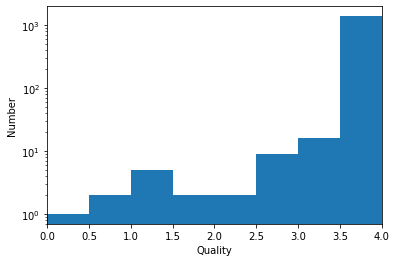

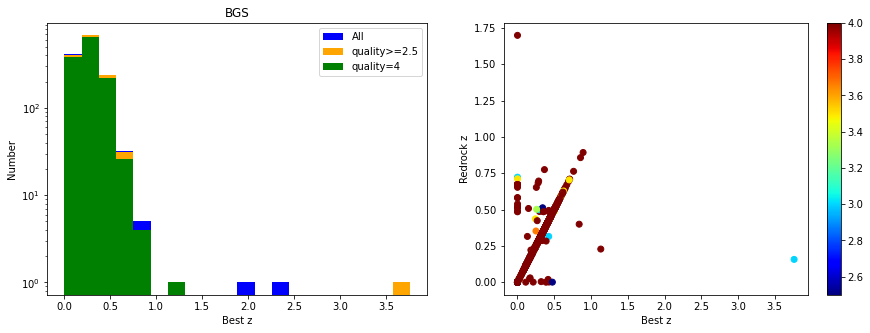

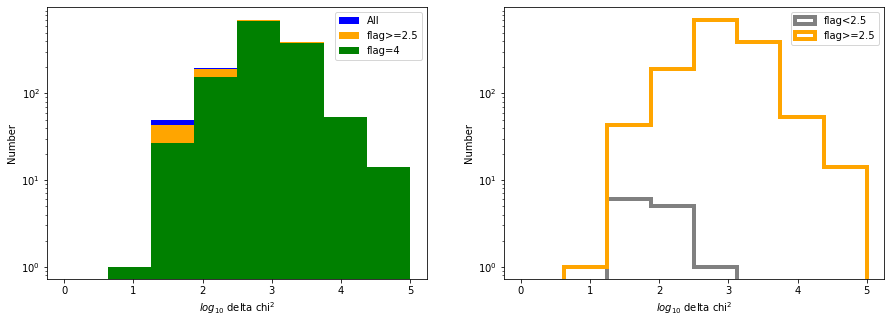

In [119]:
BGS_main = BGS[BGS['setting_name']=='sel0']
print_simple_number(BGS_main,'BGS')
plot_redshift_distribution(BGS_main,'BGS')
plot_chi2_quality_distribution(BGS_main)

In [120]:
catalog_BGS_match = BGS_main.merge(new_catalog_denali,on='TARGETID',how='left',suffixes=("_cascades","_denali"))
final_match_catalog = catalog_BGS_match[catalog_BGS_match['TILEID_cascades']==catalog_BGS_match['TILEID_denali']]
final_match_catalog['dz']=abs(final_match_catalog['Z']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])
#
final_match_catalog['Z_cascades']=final_match_catalog['Redrock_z']
final_match_catalog['Redrock_z']=final_match_catalog['Z']
cut_catalog = final_match_catalog[(final_match_catalog['dz']>0.0033) & (final_match_catalog['best_quality']>=2.5)]

<ipython-input-120-cf41fce8ef43>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['dz']=abs(final_match_catalog['Z']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])
<ipython-input-120-cf41fce8ef43>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['Z_cascades']=final_match_catalog['Redrock_z']
<ipython-input-120-cf41fce8ef43>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

Number of BGS : 1399
Number of  BGS with quality>=2.5: 1387  | fration= 0.9914224446032881
Number of  BGS with quality==4: 1301  | fration= 0.9299499642601858
Number of  BGS with consistent z (with quality>=2.5): 1335 | fraction= 0.954253037884203
---------
Fraction of objects with quality>=2.5
Star: 0.09084354722422494
Galaxy: 0.8976207642393655
QSO: 0.011535688536409516


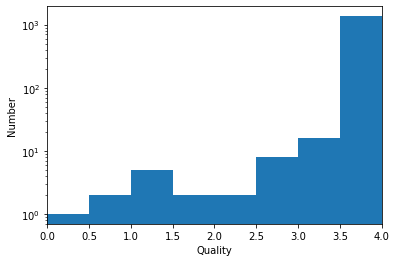

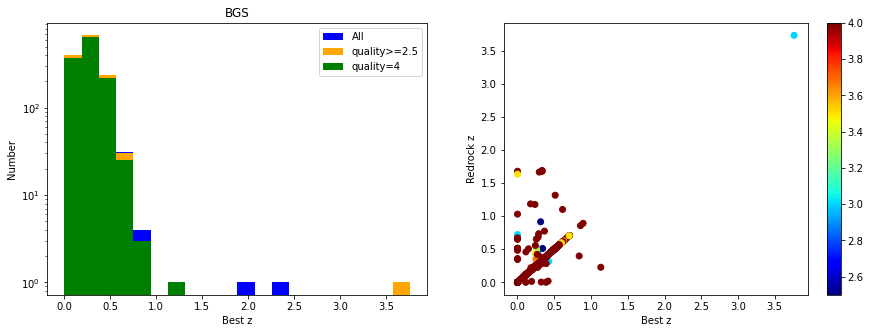

In [121]:
print_simple_number(final_match_catalog,'BGS')
plot_redshift_distribution(final_match_catalog,'BGS')

52
52


Text(0, 0.5, 'Best VI redshift')

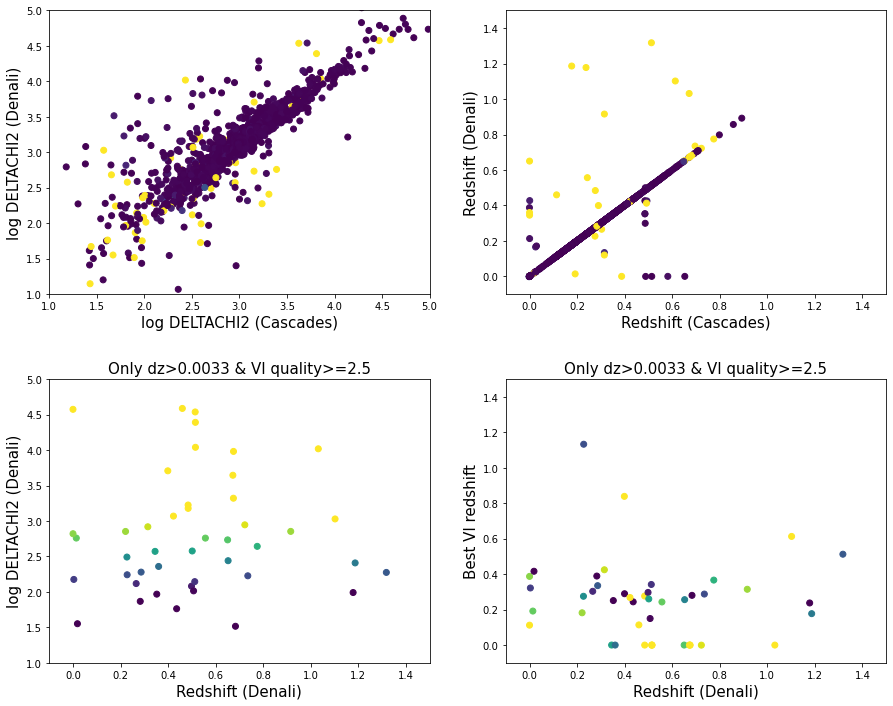

In [128]:
plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=0.3)
plt.subplot(2,2,1)
plt.scatter(np.log10(final_match_catalog['DELTACHI2_cascades']),np.log10(final_match_catalog['DELTACHI2_denali']),c=final_match_catalog['dz'],vmin=0,vmax=0.0033)
plt.xlim(1,5)
plt.ylim(1,5)
plt.xlabel('log DELTACHI2 (Cascades)',fontsize=15)
plt.ylabel('log DELTACHI2 (Denali)',fontsize=15)
plt.subplot(2,2,2)
plt.scatter(final_match_catalog['Z_cascades'],final_match_catalog['Z'],c=final_match_catalog['dz'],vmin=0,vmax=0.0033)
plt.xlim(-0.1,1.5)
plt.ylim(-0.1,1.5)
plt.xlabel('Redshift (Cascades)',fontsize=15)
plt.ylabel('Redshift (Denali)',fontsize=15)
plt.subplot(2,2,3)
plt.scatter(cut_catalog['Z'],np.log10(cut_catalog['DELTACHI2_denali']),c=np.log10(cut_catalog['DELTACHI2_denali']),vmin=2,vmax=3)
print(len(cut_catalog['Z']))
plt.xlim(-0.1,1.5)
plt.ylim(1,5)
plt.title('Only dz>0.0033 & VI quality>=2.5',fontsize=15)
plt.xlabel('Redshift (Denali)',fontsize=15)
plt.ylabel('log DELTACHI2 (Denali)',fontsize=15)
plt.subplot(2,2,4)
plt.scatter(cut_catalog['Z'],cut_catalog['best_z'],c=np.log10(cut_catalog['DELTACHI2_denali']),vmin=2,vmax=3)
print(len(cut_catalog['Z']))
plt.title('Only dz>0.0033 & VI quality>=2.5',fontsize=15)
plt.xlim(-0.1,1.5)
plt.ylim(-0.1,1.5)
plt.xlabel('Redshift (Denali)',fontsize=15)
plt.ylabel('Best VI redshift',fontsize=15)

# BGS with z_deep>0.9

Number of BGS : 428
Number of  BGS with quality>=2.5: 411  | fration= 0.9602803738317757
Number of  BGS with quality==4: 373  | fration= 0.8714953271028038
Number of  BGS with consistent z (with quality>=2.5): 90 | fraction= 0.2102803738317757
---------
Fraction of objects with quality>=2.5
Star: 0.12895377128953772
Galaxy: 0.6423357664233577
QSO: 0.22871046228710462


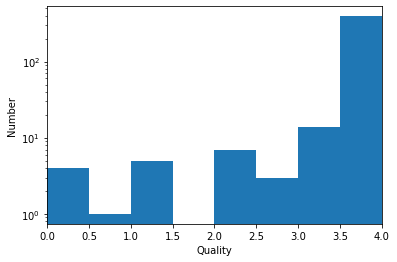

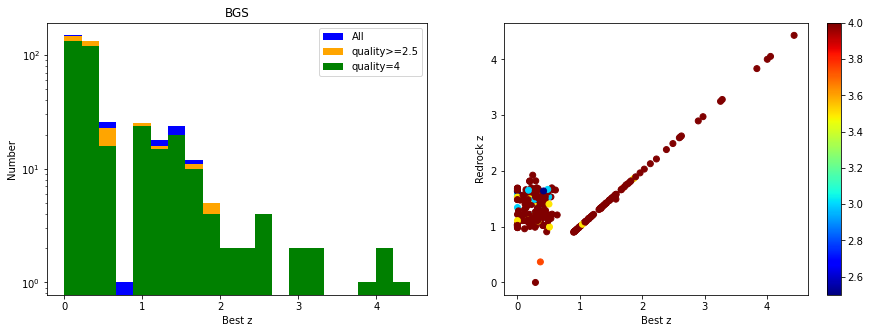

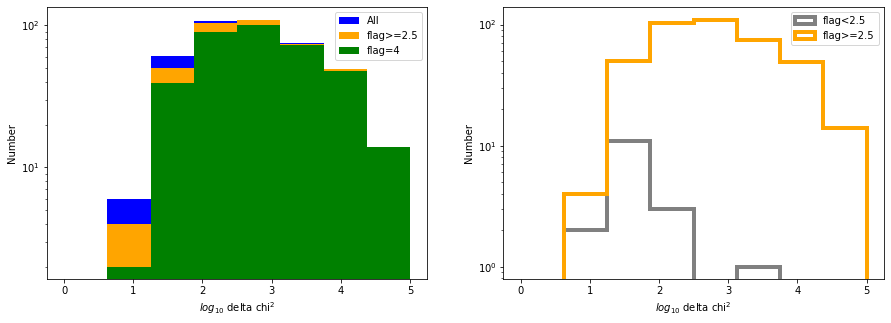

In [130]:
BGS_highz = BGS[BGS['setting_name']=='sel1']
print_simple_number(BGS_highz,'BGS')
plot_redshift_distribution(BGS_highz,'BGS')
plot_chi2_quality_distribution(BGS_highz)

In [131]:
catalog_BGS_match = BGS_highz.merge(new_catalog_denali,on='TARGETID',how='left',suffixes=("_cascades","_denali"))

### Comparing the Denali redshift and the best z

The consistency increases from 20% to 70%!!

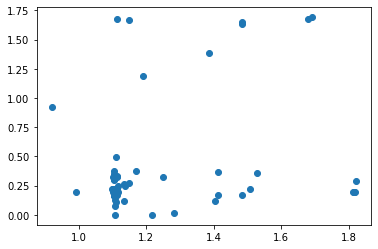

In [132]:
final_match_catalog = catalog_BGS_match[catalog_BGS_match['TILEID_cascades']==catalog_BGS_match['TILEID_denali']]
plt.scatter(final_match_catalog['Redrock_z'][final_match_catalog['TILEID_denali']==80643],final_match_catalog['Z'][final_match_catalog['TILEID_denali']==80643])

<ipython-input-133-2f8f44ef99ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['Z_cascades']=final_match_catalog['Redrock_z']
<ipython-input-133-2f8f44ef99ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['Redrock_z']=final_match_catalog['Z']


Number of BGS : 408
Number of  BGS with quality>=2.5: 391  | fration= 0.9583333333333334
Number of  BGS with quality==4: 355  | fration= 0.8700980392156863
Number of  BGS with consistent z (with quality>=2.5): 279 | fraction= 0.6838235294117647
---------
Fraction of objects with quality>=2.5
Star: 0.1278772378516624
Galaxy: 0.639386189258312
QSO: 0.23273657289002558


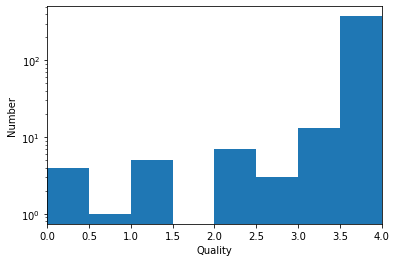

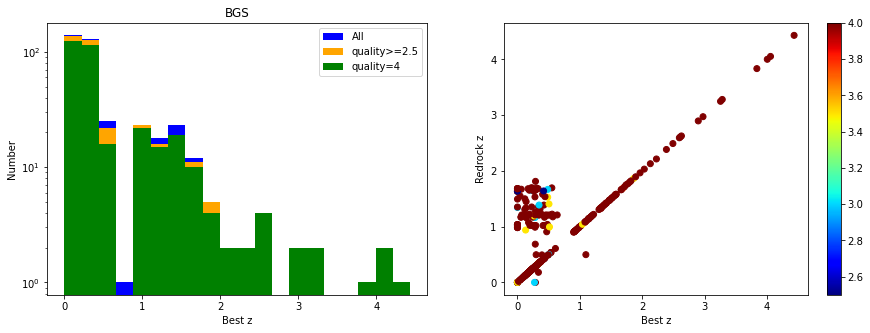

In [133]:
final_match_catalog['Z_cascades']=final_match_catalog['Redrock_z']
final_match_catalog['Redrock_z']=final_match_catalog['Z']

print_simple_number(final_match_catalog,'BGS')
plot_redshift_distribution(final_match_catalog,'BGS')
#plot_chi2_quality_distribution(final_match_catalog)

In [134]:
final_match_catalog['dz']=abs(final_match_catalog['Z']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])

<ipython-input-134-d90767f6f3de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_match_catalog['dz']=abs(final_match_catalog['Z']-final_match_catalog['best_z'])/(1.+final_match_catalog['best_z'])


In [135]:
cut_catalog = final_match_catalog[(final_match_catalog['dz']>0.0033) & (final_match_catalog['best_quality']>=2.5)]

112
112


Text(0, 0.5, 'Best VI redshift')

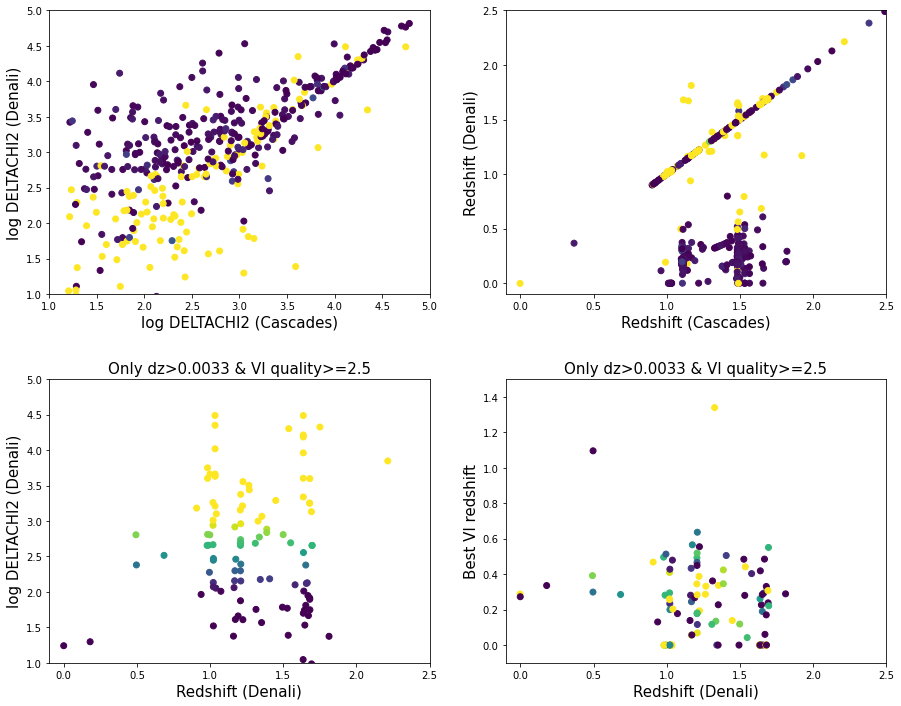

In [137]:
plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=0.3)
plt.subplot(2,2,1)
plt.scatter(np.log10(final_match_catalog['DELTACHI2_cascades']),np.log10(final_match_catalog['DELTACHI2_denali']),c=final_match_catalog['dz'],vmin=0,vmax=0.0033)
plt.xlim(1,5)
plt.ylim(1,5)
plt.xlabel('log DELTACHI2 (Cascades)',fontsize=15)
plt.ylabel('log DELTACHI2 (Denali)',fontsize=15)
plt.subplot(2,2,2)
plt.scatter(final_match_catalog['Z_cascades'],final_match_catalog['Z'],c=final_match_catalog['dz'],vmin=0,vmax=0.0033)
plt.xlim(-0.1,2.5)
plt.ylim(-0.1,2.5)
plt.xlabel('Redshift (Cascades)',fontsize=15)
plt.ylabel('Redshift (Denali)',fontsize=15)
plt.subplot(2,2,3)
plt.scatter(cut_catalog['Z'],np.log10(cut_catalog['DELTACHI2_denali']),c=np.log10(cut_catalog['DELTACHI2_denali']),vmin=2,vmax=3)
print(len(cut_catalog['Z']))
plt.xlim(-0.1,2.5)
plt.ylim(1,5)
plt.title('Only dz>0.0033 & VI quality>=2.5',fontsize=15)
plt.xlabel('Redshift (Denali)',fontsize=15)
plt.ylabel('log DELTACHI2 (Denali)',fontsize=15)
plt.subplot(2,2,4)
plt.scatter(cut_catalog['Z'],cut_catalog['best_z'],c=np.log10(cut_catalog['DELTACHI2_denali']),vmin=2,vmax=3)
print(len(cut_catalog['Z']))
plt.title('Only dz>0.0033 & VI quality>=2.5',fontsize=15)
plt.xlim(-0.1,2.5)
plt.ylim(-0.1,1.5)
plt.xlabel('Redshift (Denali)',fontsize=15)
plt.ylabel('Best VI redshift',fontsize=15)